## Random Sample Imputation Analysis

**Description**

Random sample imputation is a technique for handling missing data by replacing missing values with randomly selected values from the same variable. This approach ensures that the distribution of the variable remains intact, as the imputed values are drawn directly from the existing data. 

**Advantages**

By preserving the original distribution, random sample imputation avoids the biases that can be introduced by systematic methods like mean or median imputation. It is a straightforward method that works effectively for both numerical and categorical variables, maintaining the natural variability within the data.

**Disadvantages**

However, random sample imputation relies on the assumption that the observed data is representative of the missing data. If the missing data pattern is not random, the imputation can introduce bias. In small datasets or cases where the data is sparse, the imputed values may fail to reflect the true distribution accurately. 

Additionally, the method does not account for relationships between variables, which can limit its applicability in datasets with strong interdependencies. While the randomness introduced by this method can be beneficial in maintaining variability, it may also increase noise, particularly when the proportion of missing data is high.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from feature_engine.imputation import RandomSampleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

In [3]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


Lets visualize how many data points are we missing

In [4]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

### Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

X_train.shape, X_test.shape

((425, 23), (183, 23))

In [6]:
imputer  = RandomSampleImputer(random_state=42)
imputer.fit(X_train)

RandomSampleImputer(random_state=42)

Great. lets see if our imputation method worked

In [7]:
X_train_t = imputer.transform(X_train)
X_test_t = imputer.transform(X_test)

dataframes = [
    X_train_t, X_test_t, 
]

for df in dataframes:
    if df.isna().any().all() == False:
        print("No missing values in any dataframe")
        break
    else:
        print("Still missing values")

No missing values in any dataframe


### Check for normal distribution and skewness change 

In [8]:
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis

def check_normality(data):
    
    results = {}

    for column in data.columns:  
        stat, p = shapiro(data[column].dropna())
        skewness = skew(data[column].dropna())
        kurt = kurtosis(data[column].dropna())
        results[column] = {'Statistic': stat, 'p-value': p, 'Skewness': skewness, 'Kurtosis': kurt, 'Normal': p > 0.05} 

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results).T
    return results_df

In [9]:
X_train_norm = check_normality(X_train_copy)
X_test_norm = check_normality(X_test_copy)

X_train_norm_rs = check_normality(X_train_t)
X_test_norm_rs = check_normality(X_test_t)

In [10]:
normal_train_df = pd.DataFrame({"p-value": X_train_norm["p-value"],
                                "Skewness": X_train_norm["Skewness"],
                                "Kurtosis": X_train_norm["Kurtosis"],
                                "X_train_norm": X_train_norm["Normal"],
                                
                                "p-value_rs": X_train_norm_rs["p-value"],
                                "Skewness_rs": X_train_norm_rs["Skewness"],
                                "Kurtosis_rs": X_train_norm_rs["Kurtosis"],
                                "X_train_rs": X_train_norm_rs["Normal"],
})

normal_test_df = pd.DataFrame({"p-value": X_test_norm["p-value"],
                                "Skewness": X_test_norm["Skewness"],
                                "Kurtosis": X_test_norm["Kurtosis"],
                                "X_test_norm": X_test_norm["Normal"],
                                
                                "p-value_rs": X_test_norm_rs["p-value"],
                                "Skewness_rs": X_test_norm_rs["Skewness"],
                                "Kurtosis_rs": X_test_norm_rs["Kurtosis"],
                               "X_test_rs": X_test_norm_rs["Normal"]
})

In [11]:
normal_train_df

,Statistic,p-value,Skewness,Kurtosis,X_train_norm,Statistic_rs,p-value_rs,Skewness_rs,Kurtosis_rs,X_train_rs
RID,0.960571,0.0,-0.191996,-1.042352,False,0.960571,0.0,-0.191996,-1.042352,False
Gender,0.629481,0.0,0.280362,-1.921397,False,0.629481,0.0,0.280362,-1.921397,False
Ageatscreening,0.98636,0.000507,-0.352696,0.074891,False,0.98636,0.000507,-0.352696,0.074891,False
MMSE0m,0.899325,0.0,-0.86101,0.089239,False,0.898894,0.0,-0.861211,0.086653,False
HipsASMbaseline,0.962064,0.0,0.527045,-0.234448,False,0.960033,0.0,0.544107,-0.228272,False
HipsContrastbaseline,0.991863,0.022984,0.21891,-0.294576,False,0.991269,0.013139,0.225918,-0.296896,False
HipsCorelationbaseline,0.973015,0.000001,-0.465003,-0.239129,False,0.970947,0.0,-0.494831,-0.211043,False
HipsVariancebaseline,0.93952,0.0,-0.707282,-0.345891,False,0.939503,0.0,-0.711424,-0.33148,False
HipsSumAveragebaseline,0.992093,0.023528,-0.087851,-0.465718,False,0.992093,0.023528,-0.087851,-0.465718,False
HipsSumVariancebaseline,0.93146,0.0,-0.775533,-0.258937,False,0.931714,0.0,-0.776704,-0.251152,False


In [12]:
print("Total normal distribution count for X_train_norm")
print(normal_train_df["X_train_norm"].value_counts())

print("Total normal distribution count for X_train_rs")
print(normal_train_df["X_train_rs"].value_counts())

Total normal distribution count for X_train_norm
X_train_norm
False    20
True      3
Name: count, dtype: int64
Total normal distribution count for X_train_rs
X_train_rs
False    20
True      3
Name: count, dtype: int64


In [13]:
normal_test_df

,Statistic,p-value,Skewness,Kurtosis,X_test_norm,Statistic_rs,p-value_rs,Skewness_rs,Kurtosis_rs,X_test_rs
RID,0.960508,0.000051,-0.016388,-1.13125,False,0.960508,0.000051,-0.016388,-1.13125,False
Gender,0.636327,0.0,-0.032791,-1.998925,False,0.636327,0.0,-0.032791,-1.998925,False
Ageatscreening,0.980514,0.011678,-0.433128,-0.042661,False,0.980514,0.011678,-0.433128,-0.042661,False
MMSE0m,0.917092,0.0,-0.833102,0.252238,False,0.917092,0.0,-0.833102,0.252238,False
HipsASMbaseline,0.969407,0.000648,0.426523,-0.261149,False,0.966465,0.000223,0.486737,-0.123075,False
HipsContrastbaseline,0.993728,0.641145,-0.093392,-0.423827,True,0.99392,0.655554,-0.068039,-0.404184,True
HipsCorelationbaseline,0.966959,0.000316,-0.54832,-0.180166,False,0.965221,0.000163,-0.569192,-0.165566,False
HipsVariancebaseline,0.941051,0.000001,-0.751652,-0.130158,False,0.94174,0.000001,-0.746675,-0.13119,False
HipsSumAveragebaseline,0.984341,0.039599,-0.17071,-0.360171,False,0.984681,0.043037,-0.178433,-0.350813,False
HipsSumVariancebaseline,0.942657,0.000001,-0.758671,-0.07304,False,0.943734,0.000001,-0.757655,-0.057771,False


In [14]:
print("\nTotal normal distribution count for X_test_norm")
print(normal_test_df["X_test_norm"].value_counts())

print("\nTotal normal distribution count for X_test_rs")
print(normal_test_df["X_test_rs"].value_counts())


Total normal distribution count for X_test_norm
X_test_norm
False    13
True     10
Name: count, dtype: int64

Total normal distribution count for X_test_rs
X_test_rs
False    13
True     10
Name: count, dtype: int64


#### Comparison of Imputed and Original X_train Dataset

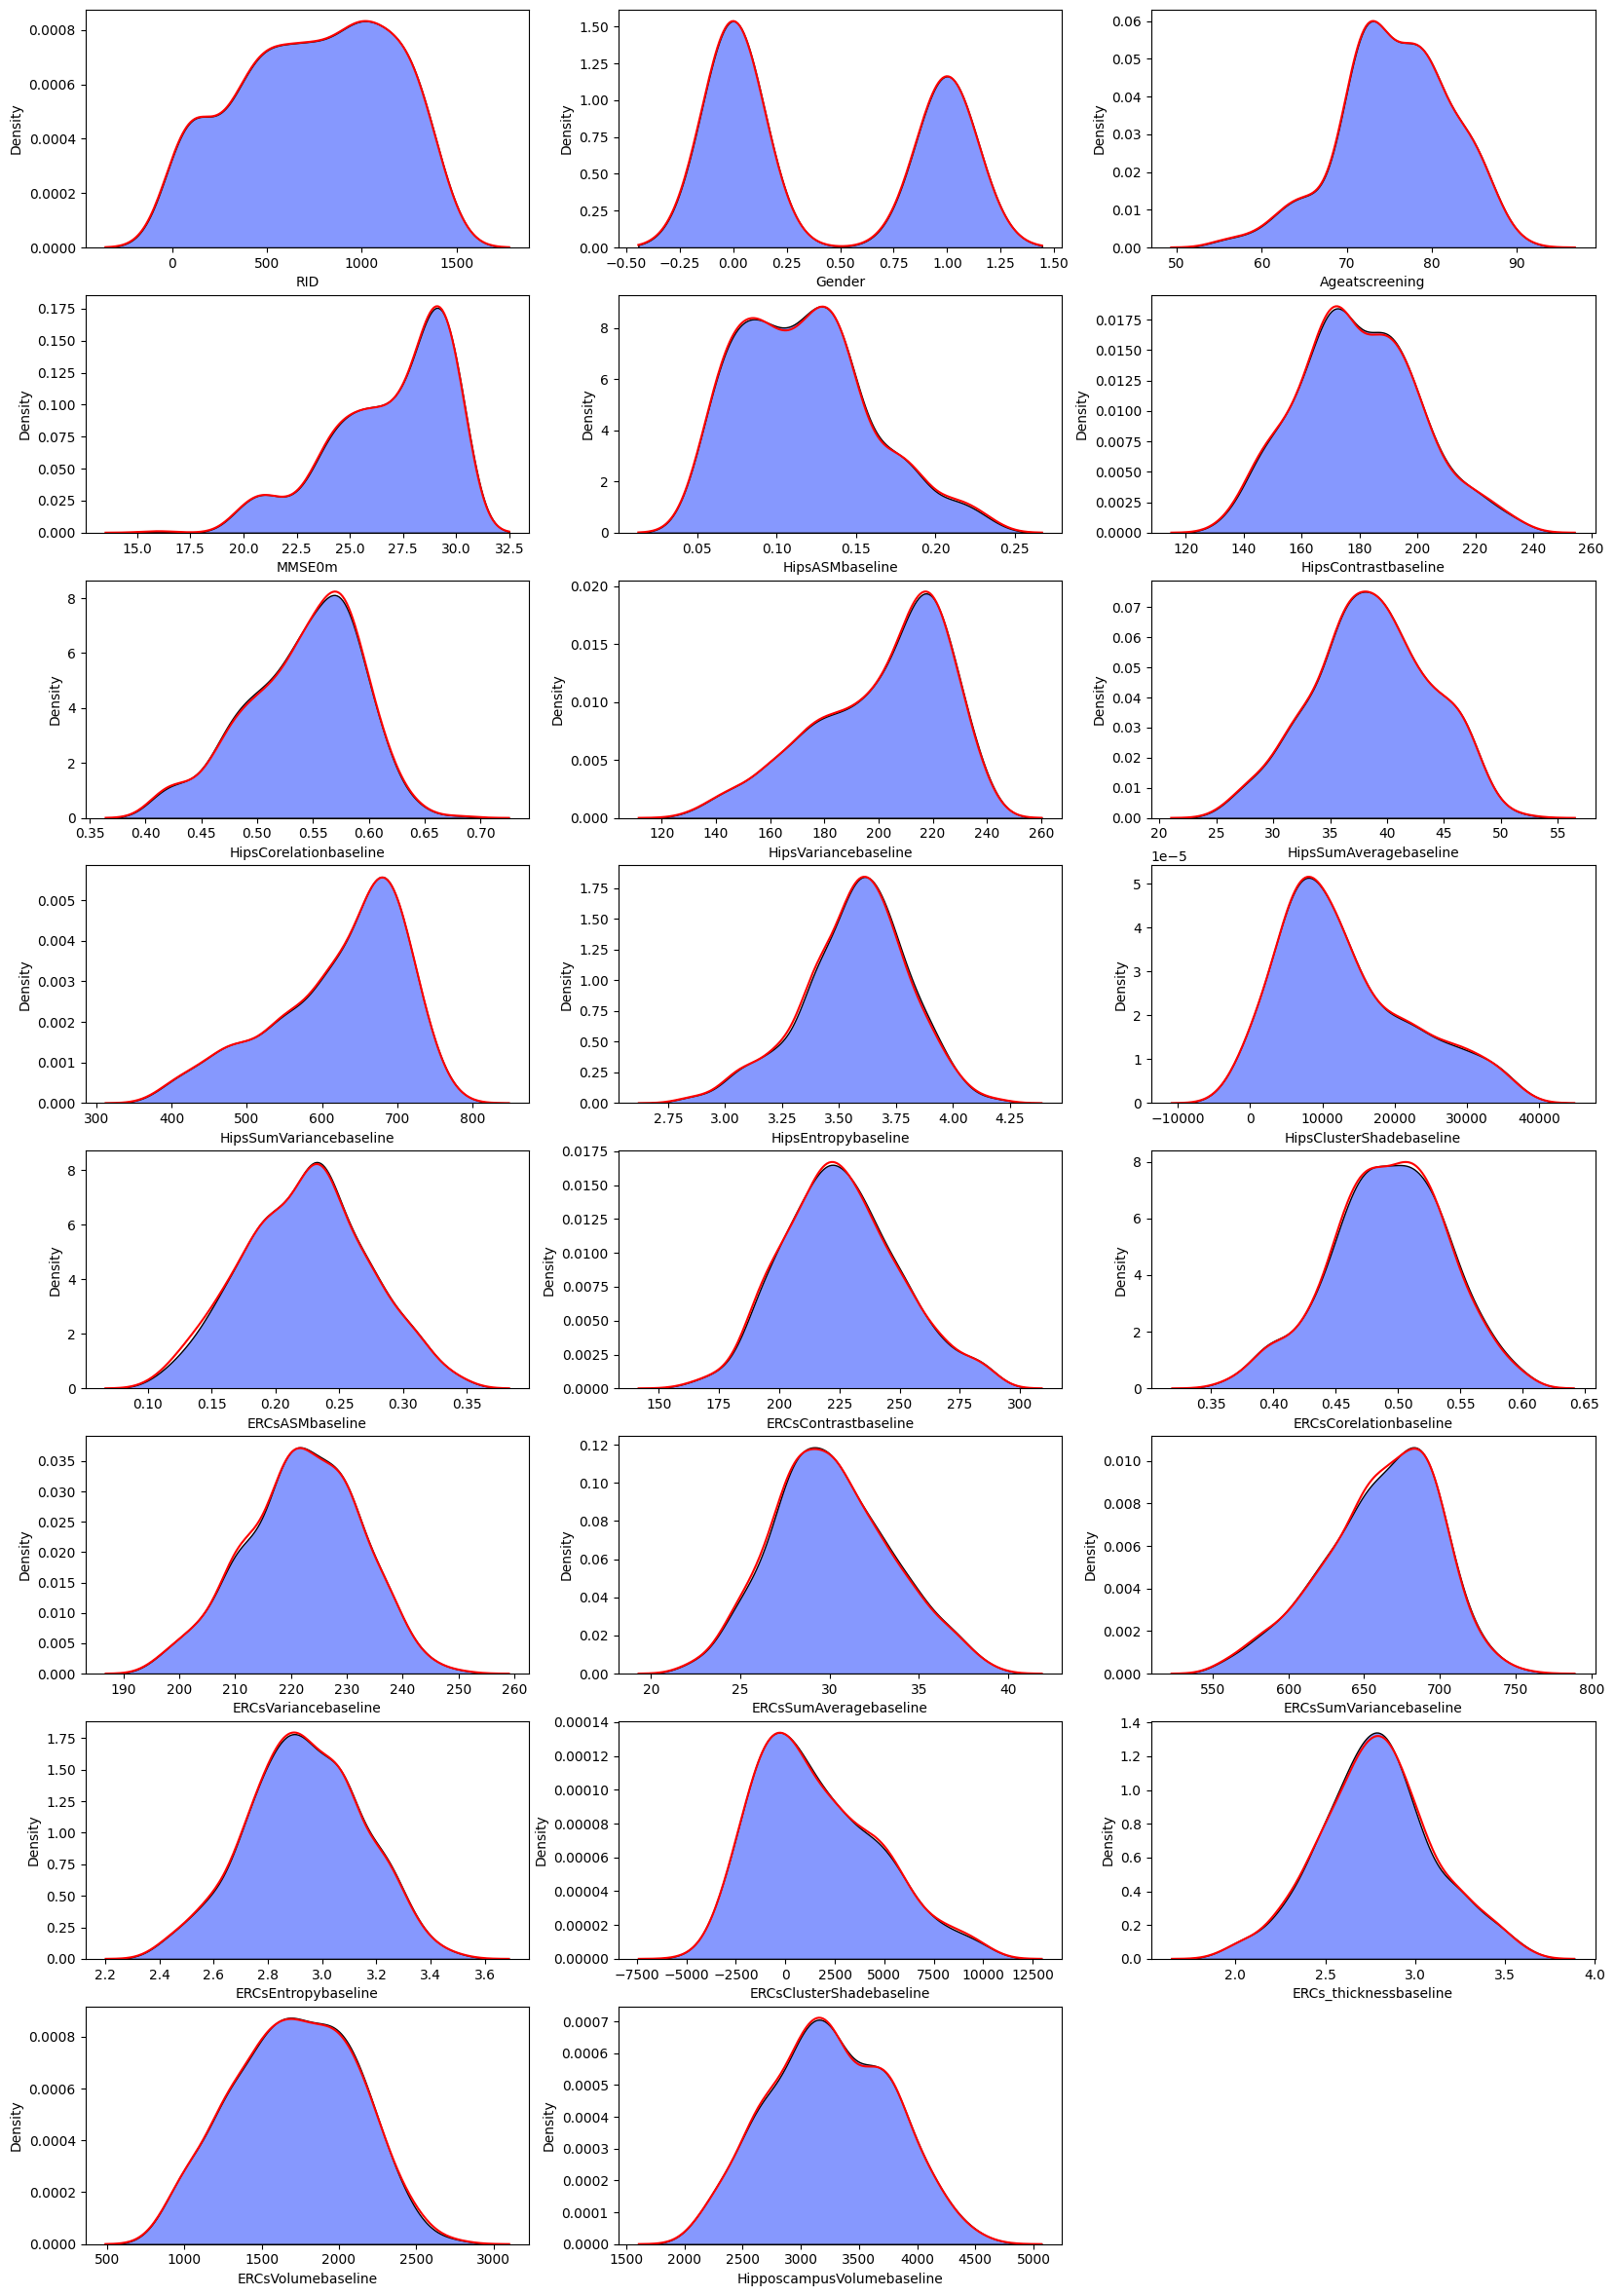

In [15]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_copy[X_train_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_t[X_train_t.columns[i]], color= "red")

It appears that we have succesfuly preserved our original variance/normal distribution using out imputation method on our training set. How about we check the difference in our testing set?

#### Comparison of Imputed and Original X_test Dataset

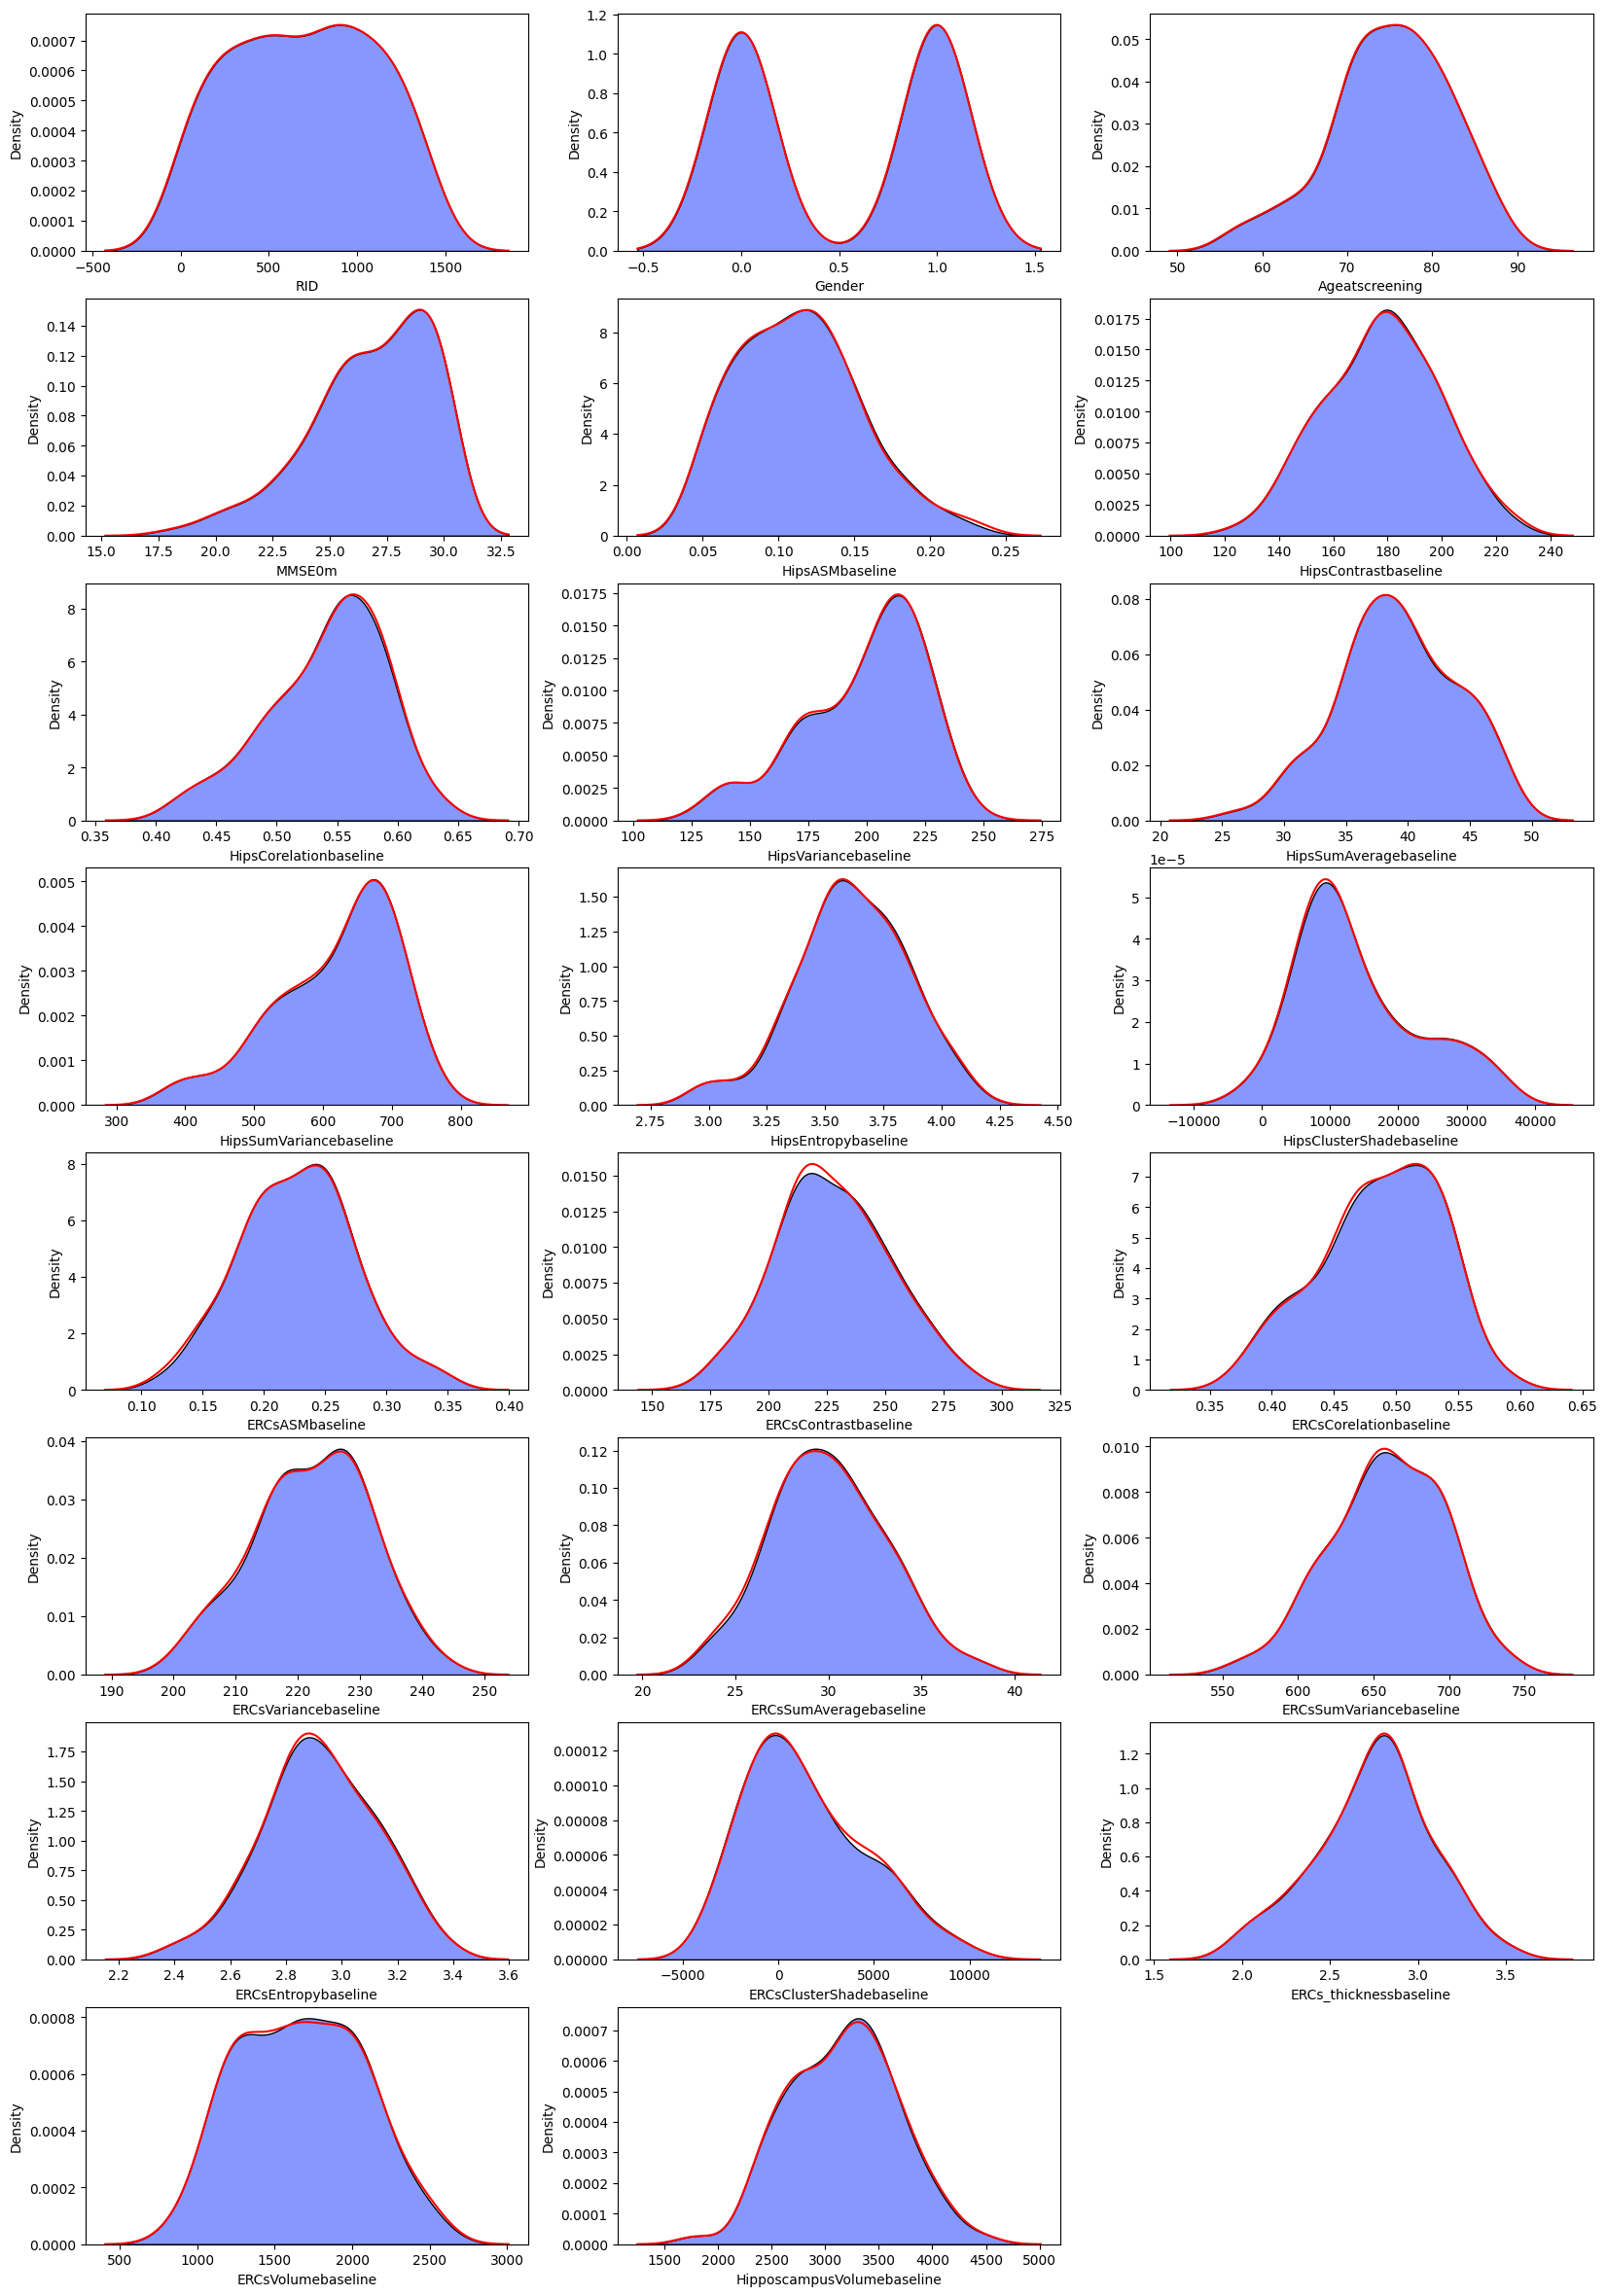

In [16]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_test_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_copy[X_test_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_t[X_test_t.columns[i]], color= "red")

It appears that in the testing set, the data imputation method has been affected a lot. How about we check the normal distribution of both the transformed train and test set?

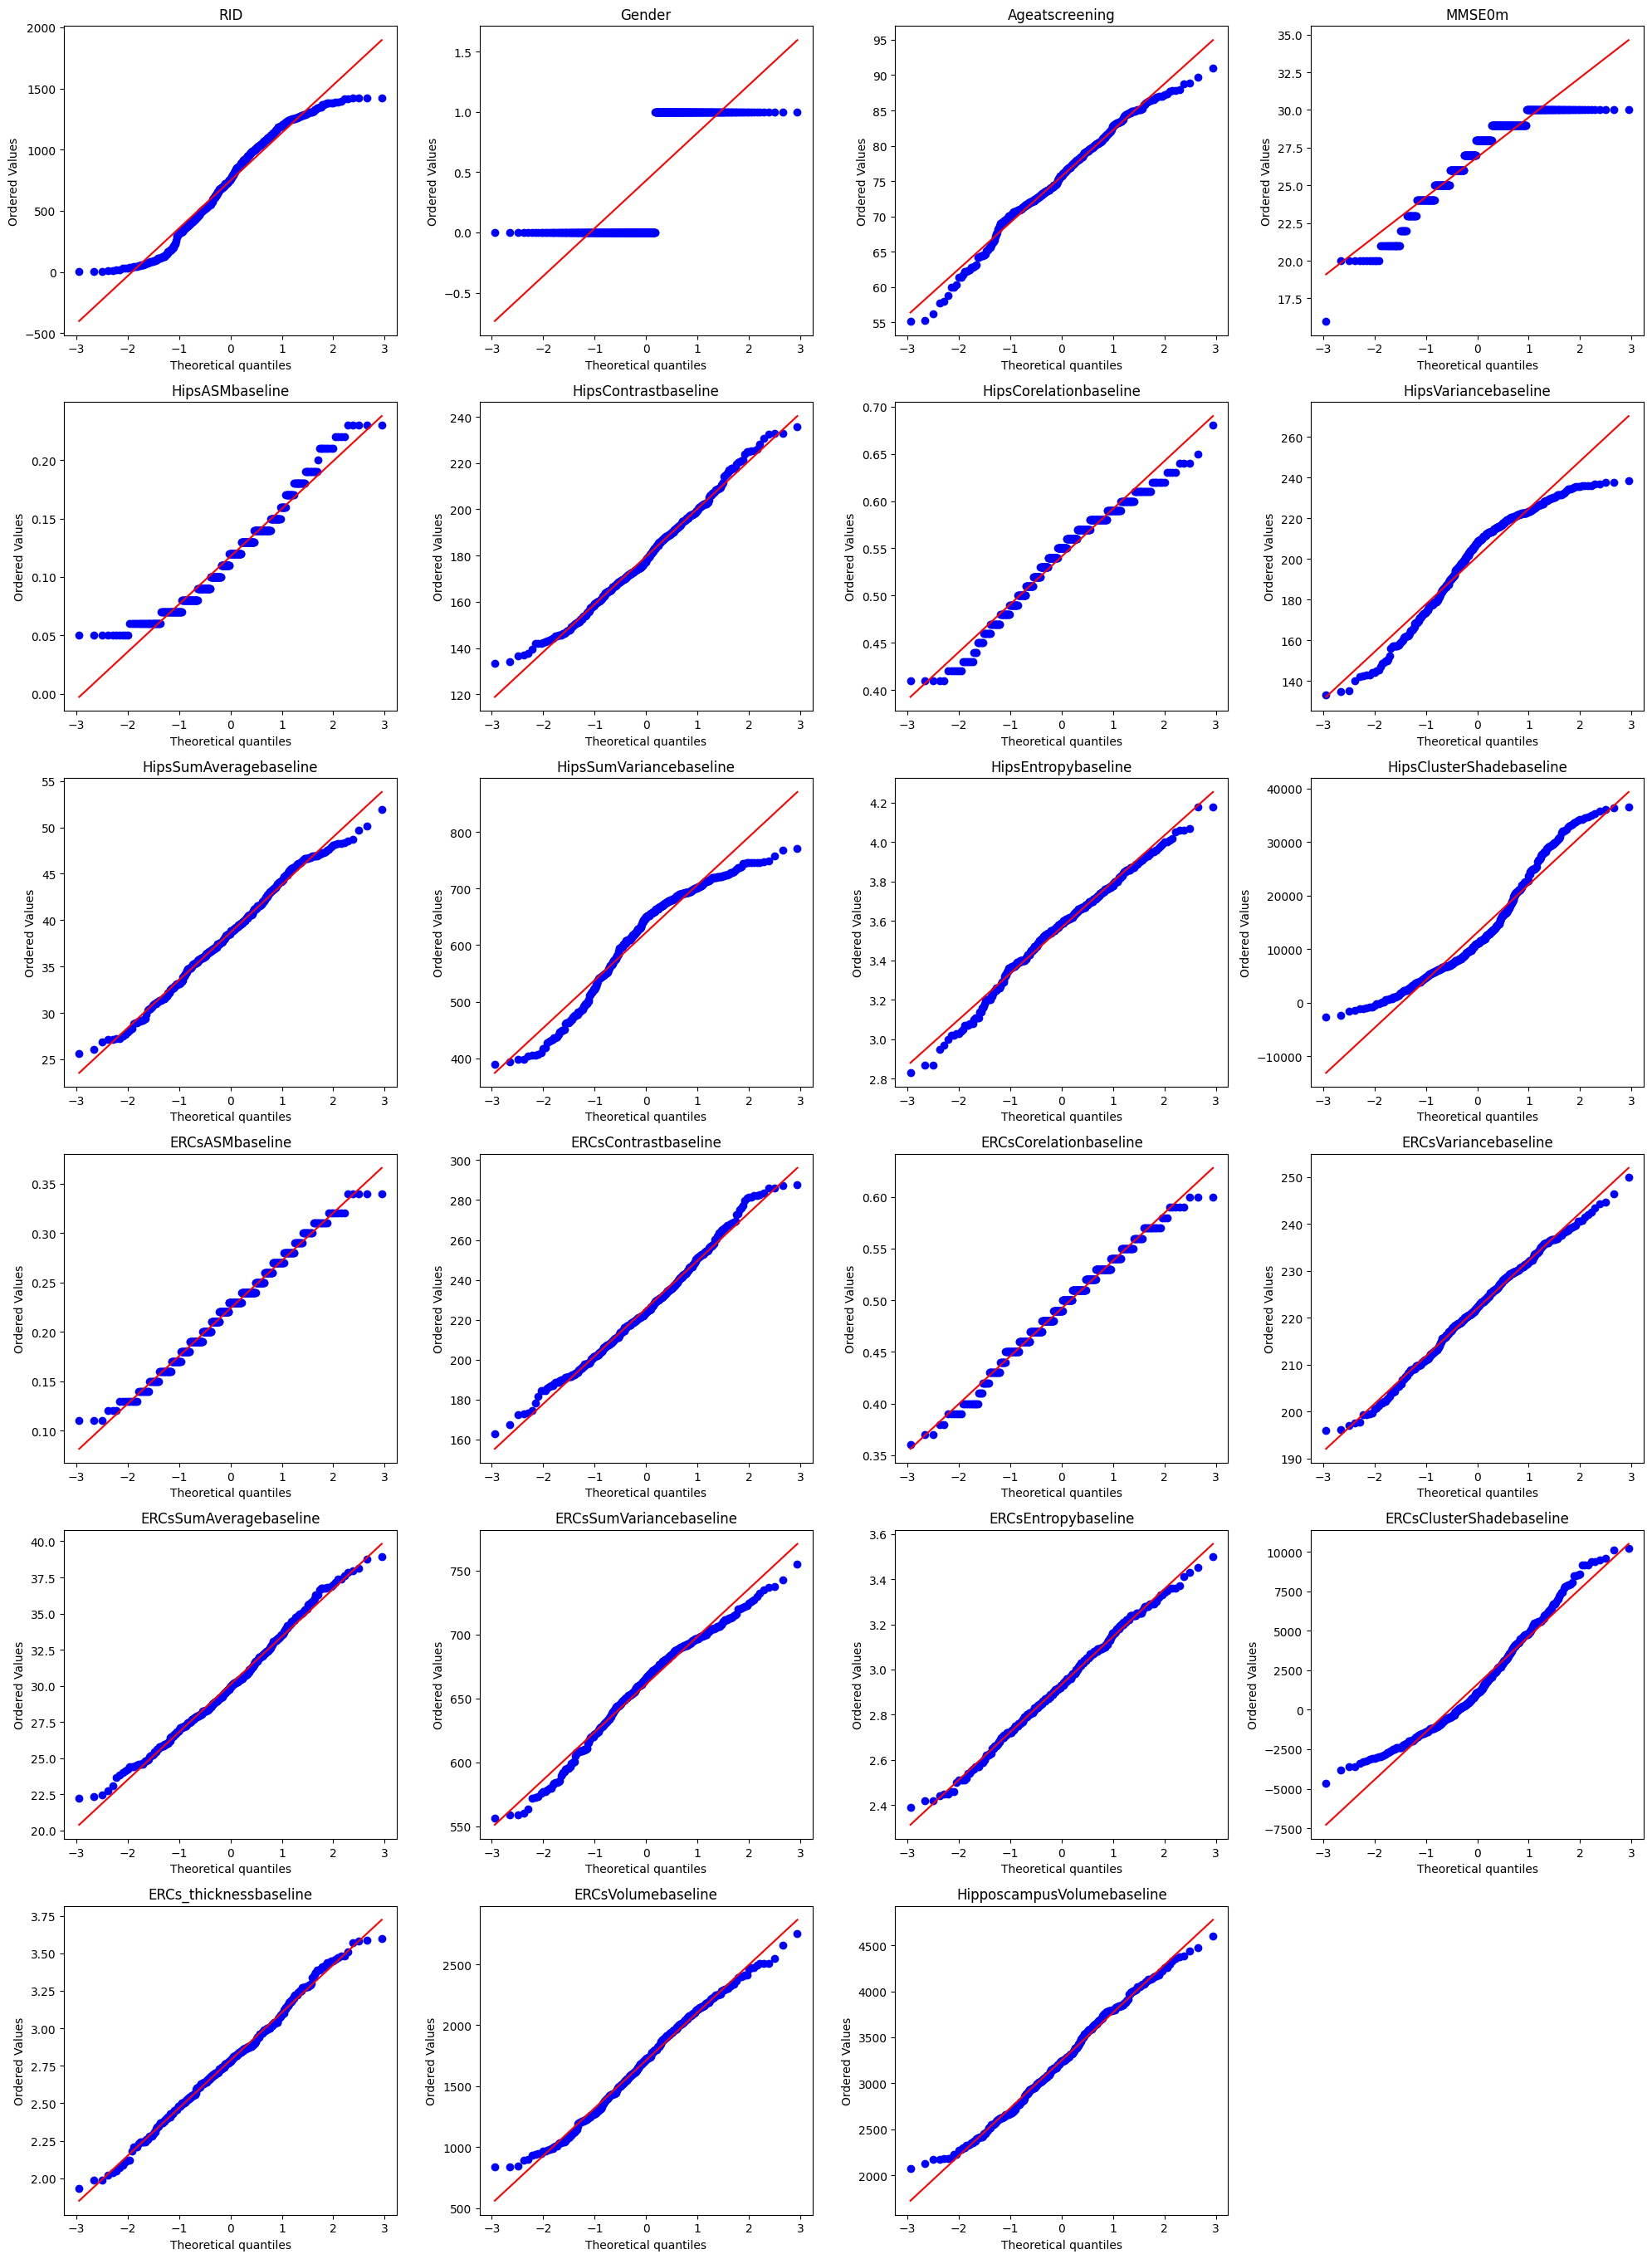

In [17]:
from scipy import stats

# Plot Q-Q plots for each column
plt.figure(figsize=(20, 45))

for i in range(len(X_train_t.columns)):
    plt.subplot(10, 4, i + 1)
    
    stats.probplot(X_train_t[X_train_t.columns[i]], 
                   dist='norm', plot=plt)
    plt.title(X_train_t.columns[i])

plt.tight_layout()

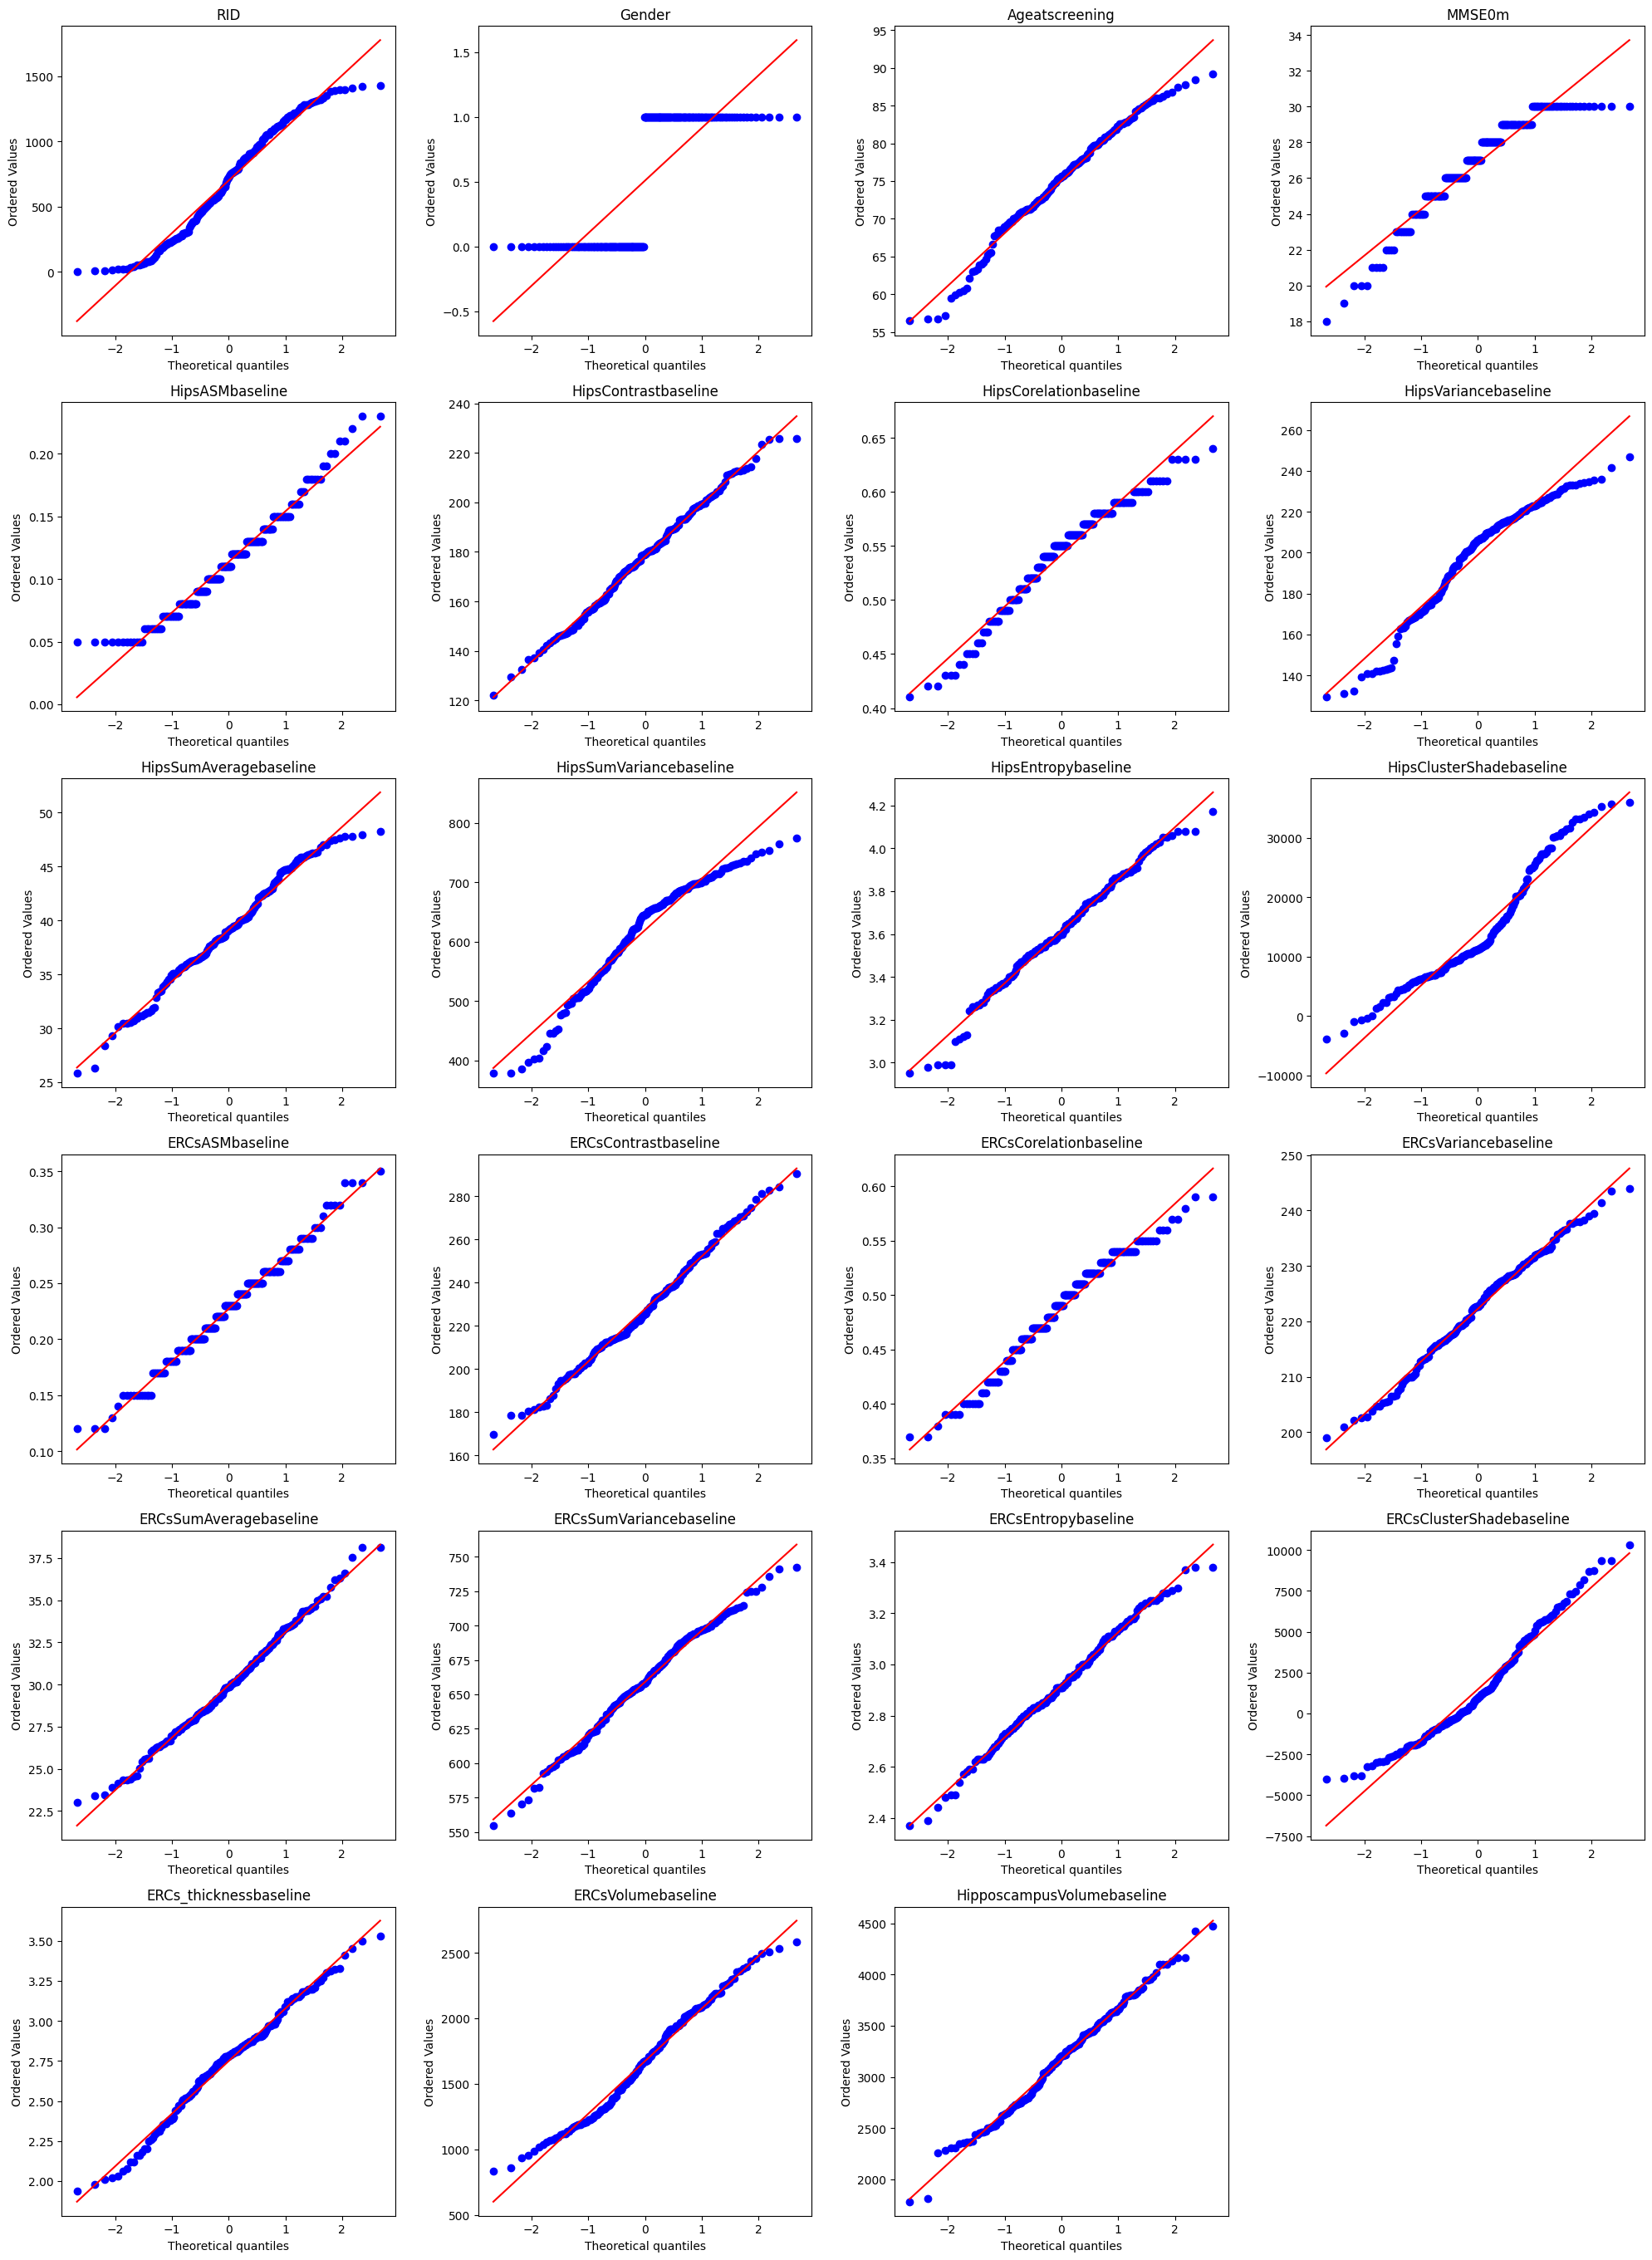

In [18]:
# Plot Q-Q plots for each column
plt.figure(figsize=(20, 45))

for i in range(len(X_test_t.columns)):
    plt.subplot(10, 4, i + 1)
    stats.probplot(X_test_t[X_test_t.columns[i]], 
                   dist='norm', plot=plt)
    plt.title(X_test_t.columns[i])

plt.tight_layout()

### Check for variance change

In [23]:
variance_train_df = pd.DataFrame({"X_train_std": X_train.var(),
              "X_train_rs std": X_train_t.var(),
            }
)

variance_train_df["Changed_train"] = (variance_train_df.nunique(axis=1) > 1)

variance_test_df = pd.DataFrame({"X_test": X_test.var(),
              "X_test_rs std": X_test_t.var(),
            }
)

variance_test_df["Changed_test"] = (variance_test_df.nunique(axis=1) > 1)

variance_df_report = pd.concat([variance_train_df, variance_test_df], axis=1)
variance_df_report

,X_train_std,X_train_rs std,Changed_train,X_test,X_test_rs std,Changed_test
RID,1.563815e+05,1.563815e+05,False,1.654556e+05,1.654556e+05,False
Gender,2.457603e-01,2.457603e-01,False,2.513061e-01,2.513061e-01,False
Ageatscreening,4.307941e+01,4.307941e+01,False,4.862086e+01,4.862086e+01,False
MMSE0m,7.689551e+00,7.675993e+00,True,7.112112e+00,7.112112e+00,False
HipsASMbaseline,1.686332e-03,1.720180e-03,True,1.611935e-03,1.655053e-03,True
HipsContrastbaseline,4.227328e+02,4.255094e+02,True,4.375496e+02,4.456304e+02,True
HipsCorelationbaseline,2.584648e-03,2.599376e-03,True,2.353091e-03,2.338287e-03,True
HipsVariancebaseline,5.847527e+02,5.800135e+02,True,6.732886e+02,6.693425e+02,True
HipsSumAveragebaseline,2.642004e+01,2.642004e+01,False,2.277794e+01,2.268464e+01,True
HipsSumVariancebaseline,7.585556e+03,7.564001e+03,True,7.896207e+03,7.832129e+03,True


In [20]:
print(variance_df_report["Changed_train"].value_counts())
print(variance_df_report["Changed_test"].value_counts())

Changed_train
True     19
False     4
Name: count, dtype: int64
Changed_test
True     19
False     4
Name: count, dtype: int64


In [21]:
variance_df_check = variance_df_report.drop(["Changed_train", "Changed_test"], axis=1)
variance_df_check

,X_train_std,X_train_rs std,X_test,X_test_rs std
RID,1.563815e+05,1.563815e+05,1.654556e+05,1.654556e+05
Gender,2.457603e-01,2.457603e-01,2.513061e-01,2.513061e-01
Ageatscreening,4.307941e+01,4.307941e+01,4.862086e+01,4.862086e+01
MMSE0m,7.689551e+00,7.675993e+00,7.112112e+00,7.112112e+00
HipsASMbaseline,1.686332e-03,1.720180e-03,1.611935e-03,1.655053e-03
HipsContrastbaseline,4.227328e+02,4.255094e+02,4.375496e+02,4.456304e+02
HipsCorelationbaseline,2.584648e-03,2.599376e-03,2.353091e-03,2.338287e-03
HipsVariancebaseline,5.847527e+02,5.800135e+02,6.732886e+02,6.693425e+02
HipsSumAveragebaseline,2.642004e+01,2.642004e+01,2.277794e+01,2.268464e+01
HipsSumVariancebaseline,7.585556e+03,7.564001e+03,7.896207e+03,7.832129e+03


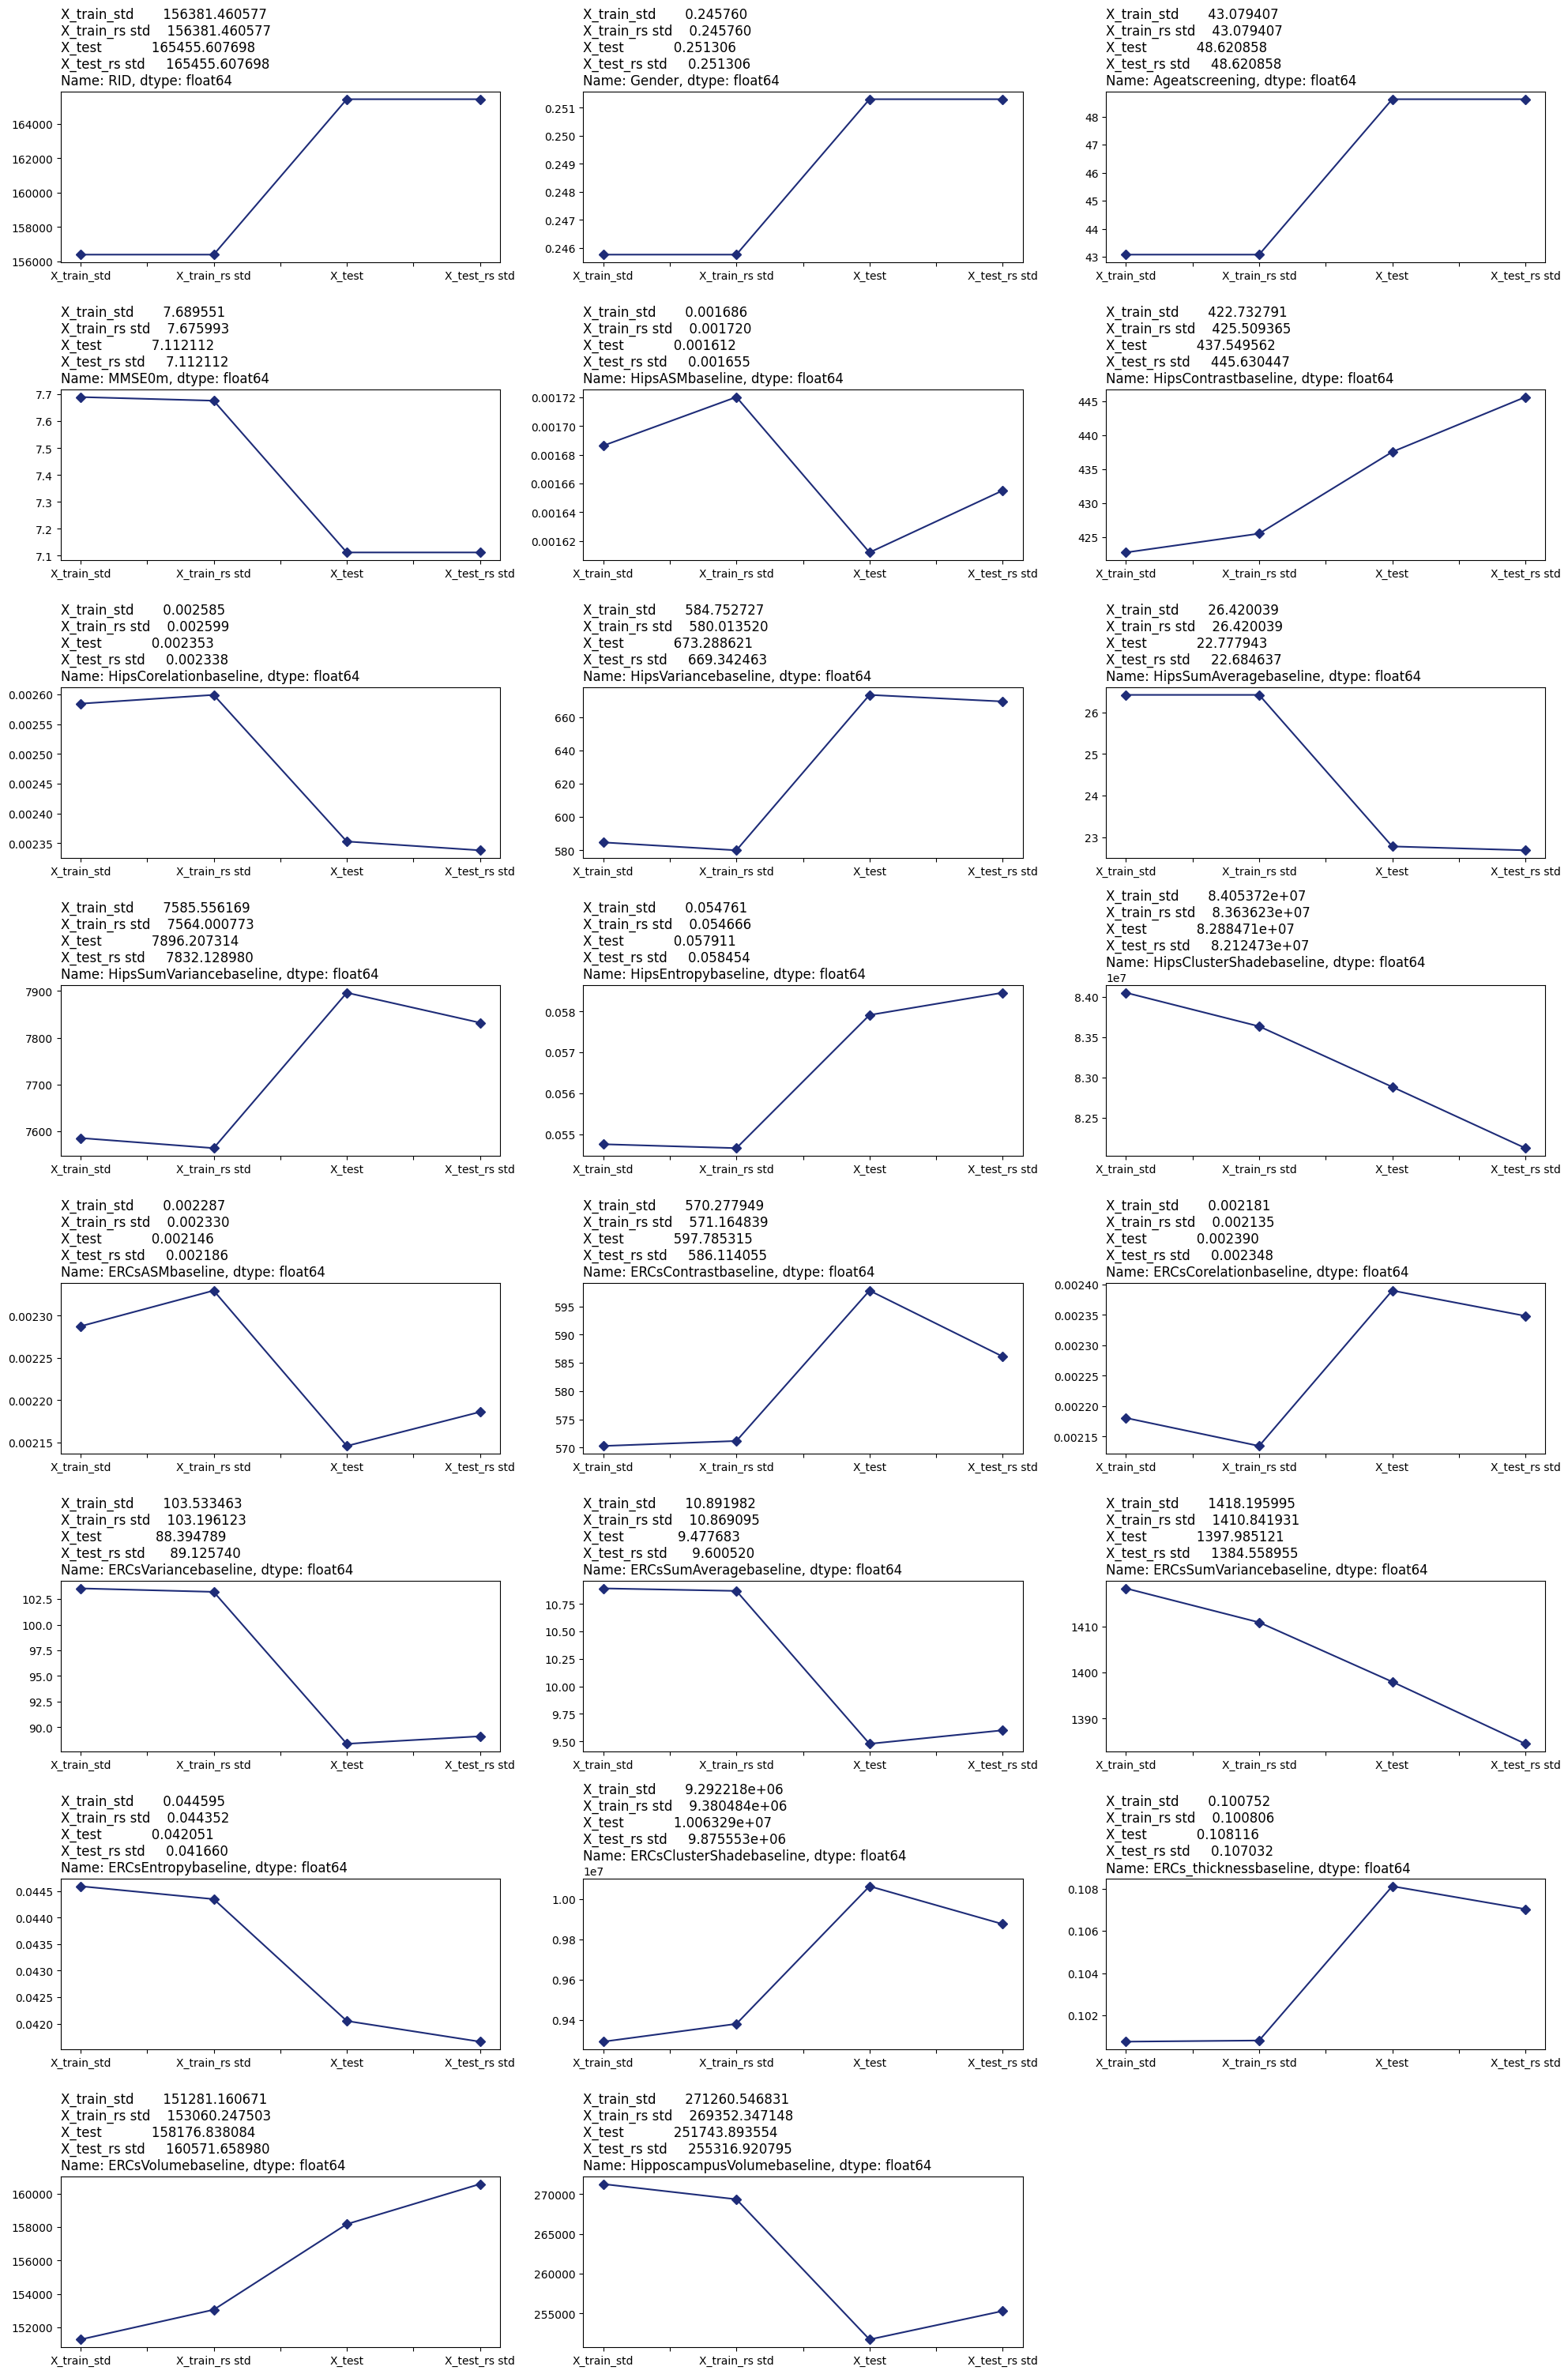

In [22]:
plt.figure(figsize=(20, 45))

for i in range(len(variance_df_check)):
    plt.subplot(12,3,i+1)
    variance_df_check.iloc[i].plot(kind="line",
                                   color="#1e2c78",
                                   marker="D",
                                   label=i,
    )
    plt.title(variance_df_check.iloc[i], loc="left")

plt.tight_layout()